In [1]:
pip install --upgrade keras


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 16.1 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 3.10.0
    Uninstalling keras-3.10.0:
      Successfully uninstalled keras-3.10.0


In [2]:
import keras
print(keras.__version__)

3.11.3


In [3]:
import numpy as np
import keras

# Load data
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
x_train = x_train.astype("float32") / 255.0
x_test  = x_test.astype("float32") / 255.0

# Add channel dimension
x_train = np.expand_dims(x_train, -1)
x_test  = np.expand_dims(x_test, -1)

def make_pairs(x, y, num_pairs_per_class=5000):
    """Create positive/negative pairs from (x, y)."""
    pairs = []
    labels = []

    # indices by class
    idx_by_class = {c: np.where(y == c)[0] for c in np.unique(y)}
    classes = list(idx_by_class.keys())

    # how many total positive pairs we’ll make
    # (keep it modest so it trains fast on Colab CPU)
    for c in classes:
        idx = idx_by_class[c]
        # positives (same class)
        pos_count = min(len(idx) // 2, num_pairs_per_class // len(classes) + 1)
        i1 = np.random.choice(idx, size=pos_count, replace=False)
        i2 = np.random.choice(idx, size=pos_count, replace=False)
        for a, b in zip(i1, i2):
            if a == b:
                continue
            pairs.append([x[a], x[b]])
            labels.append(1)

        # negatives (different class)
        neg_class = np.random.choice([k for k in classes if k != c], size=pos_count, replace=True)
        j1 = np.random.choice(idx, size=pos_count, replace=True)
        j2 = [np.random.choice(idx_by_class[nc]) for nc in neg_class]
        for a, b in zip(j1, j2):
            pairs.append([x[a], x[b]])
            labels.append(0)

    pairs = np.array(pairs)
    labels = np.array(labels).astype("float32")
    return pairs[:, 0], pairs[:, 1], labels

# Create train/test pairs
x1_train, x2_train, y_train_pairs = make_pairs(x_train, y_train, num_pairs_per_class=12000)
x1_test,  x2_test,  y_test_pairs  = make_pairs(x_test,  y_test,  num_pairs_per_class=4000)

len(x1_train), len(x1_test)

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


(24018, 8018)

In [4]:
import keras
from keras import layers
import tensorflow as tf

class L2NormalizeLayer(layers.Layer):
    def call(self, inputs):
        return tf.math.l2_normalize(inputs, axis=-1)

def get_embedding_model(input_shape=(28, 28, 1), embedding_dim=64):
    inputs = keras.Input(shape=input_shape)
    x = layers.Conv2D(32, 3, activation="relu")(inputs)
    x = layers.MaxPooling2D()(x)
    x = layers.Conv2D(64, 3, activation="relu")(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Conv2D(128, 3, activation="relu")(x)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(embedding_dim)(x)   # no activation; raw embedding
    # L2 normalize (optional, often helps distance stability)
    outputs = L2NormalizeLayer()(x)
    return keras.Model(inputs, outputs, name="embedding")

embedding = get_embedding_model()
embedding.summary()

Model: "embedding"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 3, 3, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ l2_normalize_layer              │ (None, 64)             │             0 │
│ (L2NormalizeLayer)              │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 100,928 (394.25 KB)

 Trainable params: 100,928 (394.25 KB)

 Non-trainable params: 0 (0.00 B)

In [5]:
import keras
from keras import layers
import tensorflow as tf

class L2NormalizeLayer(layers.Layer):
    def call(self, inputs):
        return tf.math.l2_normalize(inputs, axis=-1)

def get_embedding_model(input_shape=(28, 28, 1), embedding_dim=64):
    inputs = keras.Input(shape=input_shape)
    x = layers.Conv2D(32, 3, activation="relu")(inputs)
    x = layers.MaxPooling2D()(x)
    x = layers.Conv2D(64, 3, activation="relu")(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Conv2D(128, 3, activation="relu")(x)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(embedding_dim)(x)   # no activation; raw embedding
    # L2 normalize (optional, often helps distance stability)
    outputs = L2NormalizeLayer()(x)
    return keras.Model(inputs, outputs, name="embedding")

embedding = get_embedding_model()
embedding.summary()

Model: "embedding"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 3, 3, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ l2_normalize_layer_1            │ (None, 64)             │             0 │
│ (L2NormalizeLayer)              │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 100,928 (394.25 KB)

 Trainable params: 100,928 (394.25 KB)

 Non-trainable params: 0 (0.00 B)

In [6]:
# Contrastive loss
@tf.function
def contrastive_loss(y_true, y_pred, margin=1.0):
    # y_pred is the distance
    y_true = tf.cast(y_true, y_pred.dtype)
    pos_loss = y_true * tf.square(y_pred)
    neg_loss = (1.0 - y_true) * tf.square(tf.maximum(margin - y_pred, 0.0))
    return tf.reduce_mean(pos_loss + neg_loss)

# Build twin inputs
input_a = keras.Input(shape=(28, 28, 1), name="img_a")
input_b = keras.Input(shape=(28, 28, 1), name="img_b")

# Get embeddings
emb_a = embedding(input_a)
emb_b = embedding(input_b)

# L2 distance layer
distance = layers.Lambda(lambda tensors: tf.sqrt(tf.reduce_sum(tf.square(tensors[0] - tensors[1]), axis=1, keepdims=True)))(
    [emb_a, emb_b]
)

siamese = keras.Model([input_a, input_b], distance, name="siamese")

# Compile with a wrapper loss (Keras expects loss(y_true, y_pred))
siamese.compile(optimizer=keras.optimizers.Adam(1e-3),
                loss=lambda y_true, y_pred: contrastive_loss(y_true, y_pred, margin=1.0))
siamese.summary()


Model: "siamese"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ img_a (InputLayer)  │ (None, 28, 28, 1) │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ img_b (InputLayer)  │ (None, 28, 28, 1) │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 64)        │    100,928 │ img_a[0][0],      │
│ (Functional)        │                   │            │ img_b[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 1)         │          0 │ embedding[0][0],  │
│                     │                   │            │ embedding[1][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 100,928 (394.25 KB)

 Trainable params: 100,928 (394.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
94/94 ━━━━━━━━━━━━━━━━━━━━ 61s 585ms/step - loss: 0.1172 - val_loss: 0.0785
Epoch 2/5
94/94 ━━━━━━━━━━━━━━━━━━━━ 41s 437ms/step - loss: 0.0685 - val_loss: 0.0603
Epoch 3/5
94/94 ━━━━━━━━━━━━━━━━━━━━ 44s 474ms/step - loss: 0.0536 - val_loss: 0.0530
Epoch 4/5
94/94 ━━━━━━━━━━━━━━━━━━━━ 42s 448ms/step - loss: 0.0436 - val_loss: 0.0429
Epoch 5/5
94/94 ━━━━━━━━━━━━━━━━━━━━ 80s 431ms/step - loss: 0.0367 - val_loss: 0.0379


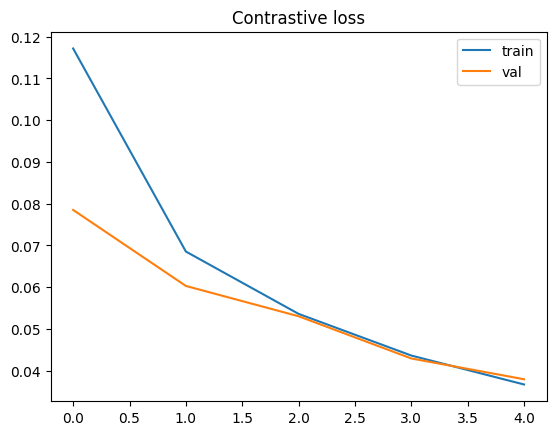

In [7]:
import matplotlib.pyplot as plt

history = siamese.fit(
    [x1_train, x2_train], y_train_pairs,
    validation_data=([x1_test, x2_test], y_test_pairs),
    epochs=5,
    batch_size=256,
    verbose=1
)

plt.plot(history.history["loss"], label="train")
plt.plot(history.history["val_loss"], label="val")
plt.title("Contrastive loss")
plt.legend(); plt.show()

In [8]:
# Compute distances on test
d_test = siamese.predict([x1_test, x2_test], batch_size=256).ravel()

# Choose threshold by scanning for best accuracy
def best_threshold(distances, labels):
    candidates = np.linspace(0.1, 1.2, 50)
    best_acc, best_t = 0.0, None
    for t in candidates:
        preds = (distances < t).astype(int)
        acc = (preds == labels).mean()
        if acc > best_acc:
            best_acc, best_t = acc, t
    return best_t, best_acc

thr, acc = best_threshold(d_test, y_test_pairs)
thr, acc


32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 96ms/step


(np.float64(0.5714285714285714), np.float64(0.9815415315540035))

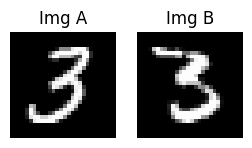

Distance: 0.154 | Pred same? 1 | True: 1


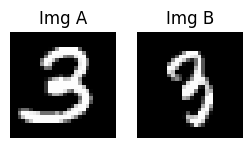

Distance: 0.275 | Pred same? 1 | True: 1


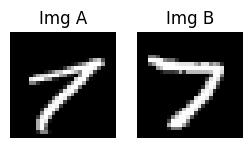

Distance: 0.095 | Pred same? 1 | True: 1


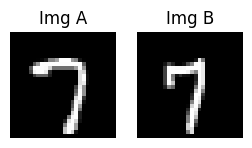

Distance: 0.115 | Pred same? 1 | True: 1


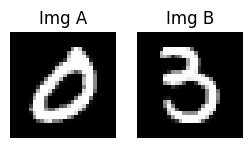

Distance: 1.265 | Pred same? 0 | True: 0


In [9]:
def show_pair(i):
    fig, ax = plt.subplots(1, 2, figsize=(3, 2))
    ax[0].imshow(x1_test[i].squeeze(), cmap="gray")
    ax[0].set_title("Img A"); ax[0].axis("off")
    ax[1].imshow(x2_test[i].squeeze(), cmap="gray")
    ax[1].set_title("Img B"); ax[1].axis("off")
    plt.show()

    d = d_test[i]
    pred = int(d < thr)
    print(f"Distance: {d:.3f} | Pred same? {pred} | True: {int(y_test_pairs[i])}")

for i in np.random.choice(len(x1_test), 5, replace=False):
    show_pair(i)


In [10]:
def embed(img):
    # Expect shape (28, 28) or (28, 28, 1)
    if img.ndim == 2:
        img = img[..., None]
    img = img.astype("float32") / 255.0
    img = np.expand_dims(img, 0)
    return embedding.predict(img, verbose=0)[0]

a = embed(x_test[0])
b = embed(x_test[1])
dist = np.linalg.norm(a - b)
print("distance:", dist, "| same?", dist < thr)


distance: 0.00061637186 | same? True


In [19]:
from sklearn.metrics import (
    roc_auc_score, roc_curve, precision_recall_fscore_support,
    confusion_matrix, accuracy_score
)
import numpy as np
import matplotlib.pyplot as plt

# y_true = y_test_pairs (0/1), d_test = distâncias no teste, thr = limiar escolhido
y_true = y_test_pairs.astype(int)
y_pred = (d_test < thr).astype(int)

# Matriz de confusão e métricas clássicas
cm = confusion_matrix(y_true, y_pred)
tn, fp, fn, tp = cm.ravel()
acc = accuracy_score(y_true, y_pred)
prec, rec, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='binary')

# AUC (usa "similaridade" = -distância)
auc = roc_auc_score(y_true, -d_test)

# Curva ROC (FPR=FAR, TPR=TAR)
fpr, tpr, thresholds = roc_curve(y_true, -d_test)

# EER (igualando FPR e FNR)
fnr = 1 - tpr
eer_idx = np.nanargmin(np.abs(fnr - fpr))
eer = (fnr[eer_idx] + fpr[eer_idx]) / 2.0
eer_thr = thresholds[eer_idx]



print("Matriz de confusão:\n", cm)
print(f"TN={tn}  FP={fp}  FN={fn}  TP={tp}")
print(f"Acurácia={acc:.3f}  Precisão={prec:.3f}  Recall={rec:.3f}  F1={f1:.3f}  AUC={auc:.3f}")



Matriz de confusão:
 [[3962   48]
 [ 100 3908]]
TN=3962  FP=48  FN=100  TP=3908
Acurácia=0.982  Precisão=0.988  Recall=0.975  F1=0.981  AUC=0.998
